In [59]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

2.5.0+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [60]:
import torch
import pandas as pd
from torch_geometric.data import Data
from torch_geometric.transforms import NormalizeFeatures

edge_data = pd.read_csv('sample_edge.csv')

edge_data['source_id'] = pd.Categorical(edge_data['source_id']).codes
edge_data['target_id'] = pd.Categorical(edge_data['target_id']).codes
edge_index = torch.tensor(edge_data[['source_id', 'target_id']].values.T, dtype=torch.long)


num_nodes = edge_index.max().item() + 1
features = torch.randn((num_nodes, 16))
labels = torch.randint(0, 2, (num_nodes,))

data = Data(x=features, edge_index=edge_index, y=labels)

data = NormalizeFeatures()(data)

dataset = [data]

data = dataset[0]

print("\nDataset Information:")
print("======================")
print(f"Number of graphs: {len(dataset)}")
print(f"Number of features: {data.num_features}")
print(f"Number of classes: {len(torch.unique(data.y))}")

print("\nGraph Information:")
print("======================")
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")
print(f"Average node degree: {data.num_edges / data.num_nodes:.2f}")
print(f"Has isolated nodes: {data.has_isolated_nodes()}")
print(f"Has self-loops: {data.has_self_loops()}")
print(f"Is undirected: {data.is_undirected()}")


data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.train_mask[:int(data.num_nodes * 0.8)] = True

print(f"Number of training nodes: {data.train_mask.sum()}")
print(f"Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}")



Dataset Information:
Number of graphs: 1
Number of features: 16
Number of classes: 2

Graph Information:
Number of nodes: 982
Number of edges: 1000
Average node degree: 1.02
Has isolated nodes: True
Has self-loops: True
Is undirected: False
Number of training nodes: 785
Training node label rate: 0.80


## Training a Multi-layer Perception Network (MLP)

In [61]:
import torch
from torch.nn import Linear
import torch.nn.functional as F

class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(data.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, len(torch.unique(data.y)))

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

model = MLP(hidden_channels=16)
print(model)

MLP(
  (lin1): Linear(in_features=16, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=2, bias=True)
)


In [64]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = MLP(hidden_channels=16)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

def train():
      model.train()
      optimizer.zero_grad()
      out = model(data.x)
      loss = criterion(out[data.train_mask], data.y[data.train_mask])
      loss.backward()
      optimizer.step()
      return loss

def test():
      model.eval()
      out = model(data.x)
      pred = out.argmax(dim=1)
      test_correct = pred[data.test_mask] == data.y[data.test_mask]
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
      return test_acc

for epoch in range(1, 201):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

#test_acc = test()
#print(f'Test Accuracy: {test_acc:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 0.6998
Epoch: 002, Loss: 0.6955
Epoch: 003, Loss: 0.6950
Epoch: 004, Loss: 0.6964
Epoch: 005, Loss: 0.6948
Epoch: 006, Loss: 0.6948
Epoch: 007, Loss: 0.6942
Epoch: 008, Loss: 0.6940
Epoch: 009, Loss: 0.6932
Epoch: 010, Loss: 0.6922
Epoch: 011, Loss: 0.6936
Epoch: 012, Loss: 0.6933
Epoch: 013, Loss: 0.6923
Epoch: 014, Loss: 0.6932
Epoch: 015, Loss: 0.6929
Epoch: 016, Loss: 0.6940
Epoch: 017, Loss: 0.6938
Epoch: 018, Loss: 0.6938
Epoch: 019, Loss: 0.6929
Epoch: 020, Loss: 0.6930
Epoch: 021, Loss: 0.6927
Epoch: 022, Loss: 0.6934
Epoch: 023, Loss: 0.6924
Epoch: 024, Loss: 0.6934
Epoch: 025, Loss: 0.6931
Epoch: 026, Loss: 0.6928
Epoch: 027, Loss: 0.6936
Epoch: 028, Loss: 0.6934
Epoch: 029, Loss: 0.6926
Epoch: 030, Loss: 0.6931
Epoch: 031, Loss: 0.6930
Epoch: 032, Loss: 0.6930
Epoch: 033, Loss: 0.6933
Epoch: 034, Loss: 0.6928
Epoch: 035, Loss: 0.6935
Epoch: 036, Loss: 0.6927
Epoch: 037, Loss: 0.6927
Epoch: 038, Loss: 0.6928
Epoch: 039, Loss: 0.6931
Epoch: 040, Loss: 0.6929


## Training a Graph Neural Network (GNN)



In [65]:
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(data.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, len(torch.unique(data.y)))

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(16, 16)
  (conv2): GCNConv(16, 2)
)


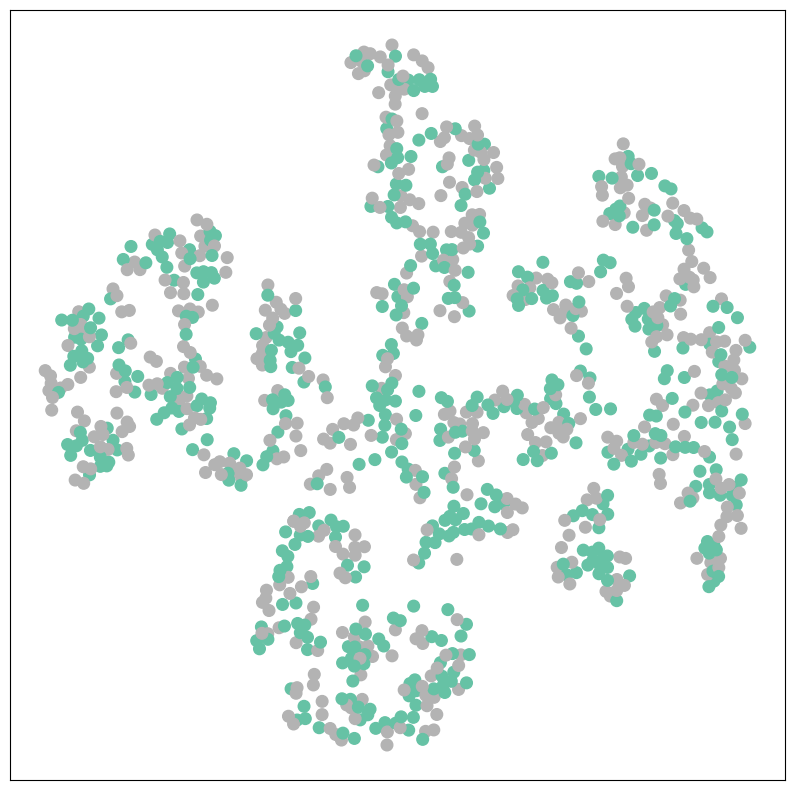

In [66]:
model = GCN(hidden_channels=16)
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

In [71]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(data.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, len(torch.unique(data.y)))

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16).to('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss

def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    test_correct = pred[data.test_mask].eq(data.y[data.test_mask])
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
    return test_acc

for epoch in range(1, 101):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

# Evaluate the model
#test_acc = test()
#print(f'Test Accuracy: {test_acc:.4f}')


<IPython.core.display.Javascript object>

Epoch: 001, Loss: 0.6922
Epoch: 002, Loss: 0.6936
Epoch: 003, Loss: 0.6914
Epoch: 004, Loss: 0.6915
Epoch: 005, Loss: 0.6934
Epoch: 006, Loss: 0.6943
Epoch: 007, Loss: 0.6950
Epoch: 008, Loss: 0.6930
Epoch: 009, Loss: 0.6930
Epoch: 010, Loss: 0.6926
Epoch: 011, Loss: 0.6927
Epoch: 012, Loss: 0.6937
Epoch: 013, Loss: 0.6925
Epoch: 014, Loss: 0.6936
Epoch: 015, Loss: 0.6930
Epoch: 016, Loss: 0.6922
Epoch: 017, Loss: 0.6948
Epoch: 018, Loss: 0.6935
Epoch: 019, Loss: 0.6932
Epoch: 020, Loss: 0.6926
Epoch: 021, Loss: 0.6927
Epoch: 022, Loss: 0.6934
Epoch: 023, Loss: 0.6933
Epoch: 024, Loss: 0.6928
Epoch: 025, Loss: 0.6930
Epoch: 026, Loss: 0.6928
Epoch: 027, Loss: 0.6932
Epoch: 028, Loss: 0.6926
Epoch: 029, Loss: 0.6931
Epoch: 030, Loss: 0.6927
Epoch: 031, Loss: 0.6926
Epoch: 032, Loss: 0.6928
Epoch: 033, Loss: 0.6928
Epoch: 034, Loss: 0.6922
Epoch: 035, Loss: 0.6924
Epoch: 036, Loss: 0.6928
Epoch: 037, Loss: 0.6927
Epoch: 038, Loss: 0.6925
Epoch: 039, Loss: 0.6923
Epoch: 040, Loss: 0.6926


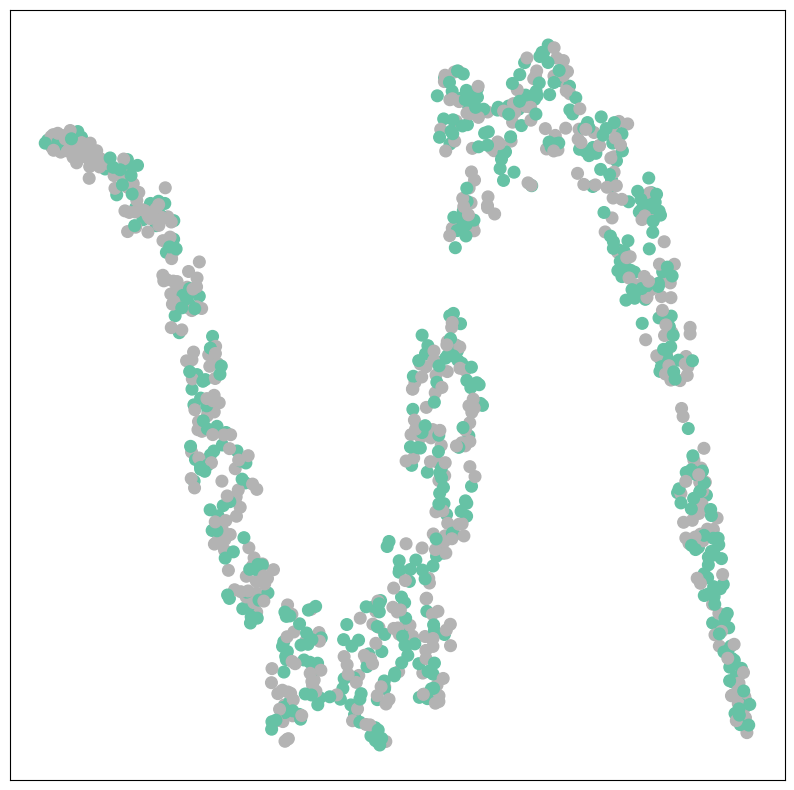

In [69]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)